C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18788\564075432.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
09:14:31 - cmdstanpy - INFO - Chain [1] start processing
09:14:33 - cmdstanpy - INFO - Chain [1] done processing


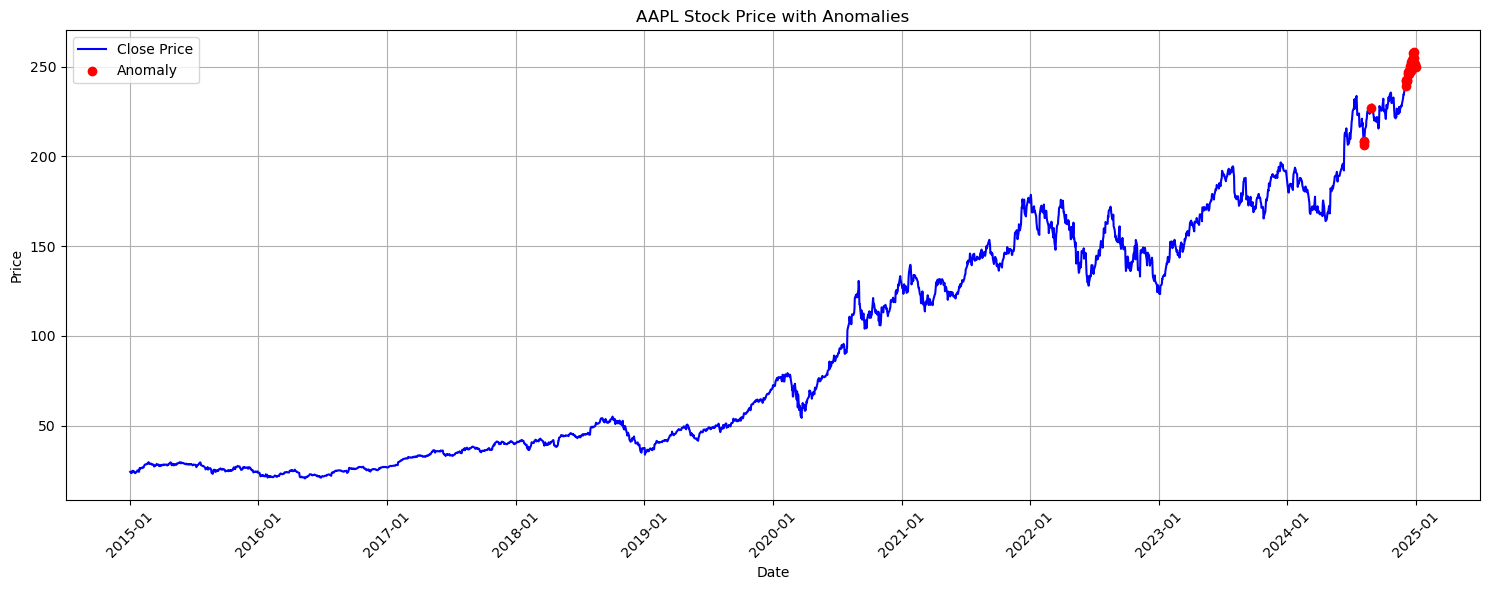

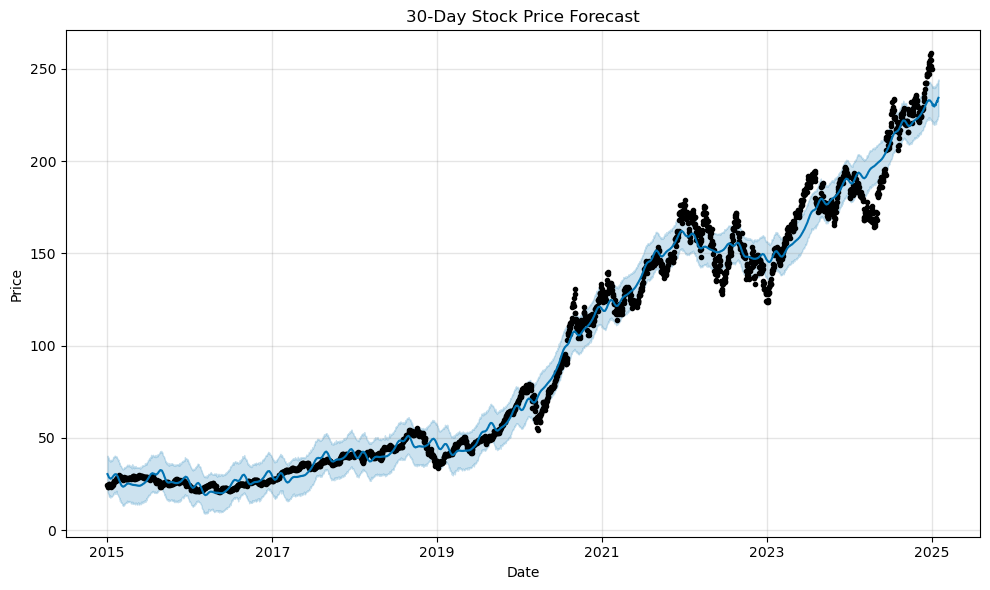

In [9]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet

# Step 1: Download stock data
def download_data(ticker, start="2015-01-01", end="2025-01-01"):
    df = yf.download(ticker, start=start, end=end)
    df.dropna(inplace=True)
    df.index.name = "Date"

    # Force 'Close' to be Series (not DataFrame)
    if isinstance(df['Close'], pd.DataFrame):
        df['Close'] = df['Close'].squeeze()

    return df

# Step 2: Add technical indicators
def add_indicators(df):
    # Force 'Close' to be a Series
    if isinstance(df['Close'], pd.DataFrame):
        df['Close'] = df['Close'].squeeze()

    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Rolling standard deviation
    std = df['Close'].rolling(window=20).std()

    # Again force all Series
    df['Upper_BB'] = df['SMA_20'] + 2 * std.squeeze()
    df['Lower_BB'] = df['SMA_20'] - 2 * std.squeeze()

    return df

# Step 3: Detect anomalies
def detect_anomalies(df):
    features = df[['Close', 'SMA_20', 'EMA_20', 'RSI']].dropna()
    model = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly'] = 0
    df.loc[features.index, 'anomaly'] = (model.fit_predict(features) == -1).astype(int)
    return df

# Step 4: Forecast future prices
def forecast_with_prophet(df):
    df_prophet = df[['Close']].copy().reset_index()
    df_prophet.columns = ['ds', 'y']
    model = Prophet(daily_seasonality=True)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    return forecast, model

# Step 5: Plot anomalies
def plot_anomalies(df, ticker):
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    if 'anomaly' in df.columns and df['anomaly'].sum() > 0:
        plt.scatter(df[df['anomaly'] == 1].index,
                    df[df['anomaly'] == 1]['Close'],
                    color='red', label='Anomaly', zorder=5)
    plt.title(f'{ticker} Stock Price with Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Step 6: Plot forecast
def plot_forecast(model, forecast):
    fig = model.plot(forecast)
    plt.title("30-Day Stock Price Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 7: Run the full analysis
def run_analysis(ticker):
    df = download_data(ticker)
    df = add_indicators(df)
    df = detect_anomalies(df)
    forecast, model = forecast_with_prophet(df)
    plot_anomalies(df, ticker)
    plot_forecast(model, forecast)
    return df, forecast

# Run analysis for AAPL
df_result, forecast_result = run_analysis('AAPL')
